In [1]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [2]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

# TODO: Winner's stats synapse.
# TODO: Bio_hebbian stats synapse.
# TODO: Stats synapse for each rez.synapse, not only for winners.
# TODO: Stats synapse for winners and second after winner.
# TODO: Push stats synapses.
# TODO: Rezonanse synapse via avg(or meadian) input.

In [66]:
def online_avg(prev_avg, prev_cnt, new_val):
    if prev_avg == 0:
        return new_val

    mn = prev_avg + ((new_val - prev_avg) / prev_cnt)

    return mn

In [64]:
layer_size = 10*4
c = 4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
WC = np.zeros(W.shape)
print('W', W.shape, W.max(), W.min(), np.median(W))

push_delta = 0.4
k = 1

prec = 1e-30

epoch_cnt = 100
eps0 = 0.0085*2.5

lr = 0.085

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0
    print(eps)

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255
        DO = np.exp((W - I)**2 * -20.0)
        O = np.sum(DO, axis=1)

        # train
        winner_ids = np.argsort(O)[::-1]

        D = np.zeros(O.shape)
        D[winner_ids[0]] = 1
        D[winner_ids[1:1+k]] = -push_delta
        D = D[np.newaxis].T
        
        # update
        O /= np.max(np.abs(O))

        O = O[np.newaxis].T

        win_id = winner_ids[0]
        W[win] = W[win] + ((I[win] - W[win]) / WC[win])
        WC[win] += 1

print('W', W.shape, W.max(), W.min(), np.median(W))

W (40, 784) 0.0009999713616498335 9.793088598830657e-09 0.0005014582554407989
2.125
2.1037500000000002
2.0825
2.0612500000000002
2.04
2.0187500000000003
1.9975
1.97625
1.955
1.93375
1.9125
1.89125
1.87
1.8487500000000001
1.8275000000000001
1.8062500000000001
1.7850000000000001
1.7637500000000002
1.7425000000000002
1.7212500000000002
1.7000000000000002
1.6787500000000002
1.6575000000000002
1.6362500000000002
1.6150000000000002
1.5937500000000002
1.5725
1.55125
1.53
1.50875
1.4875
1.46625
1.445
1.42375
1.4025
1.38125
1.36
1.33875
1.3175000000000001
1.2962500000000001
1.2750000000000001
1.2537500000000001
1.2325000000000002
1.2112500000000002
1.1900000000000002
1.1687500000000002
1.1475000000000002
1.12625
1.105
1.08375
1.0625
1.04125
1.02
0.99875
0.9775
0.95625
0.935
0.9137500000000001
0.8925000000000001
0.8712500000000001
0.8500000000000001
0.8287500000000001
0.8075000000000001
0.78625
0.765
0.74375
0.7225
0.70125
0.68
0.6587500000000001
0.6375000000000001
0.6162500000000001
0.595000000

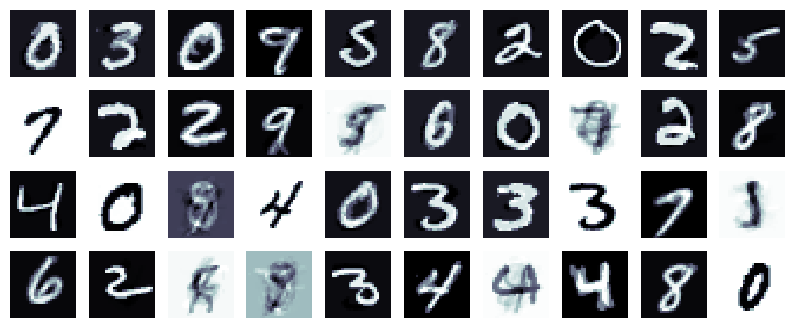

In [65]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg, interpolation='none', aspect='auto', cmap='bone')
        axis("off")

show()
